In [1]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

# Define transformations
data_transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

training_data = datasets.Flowers102(
    root="data",
    split="train",
    download=True,
    transform=data_transform_train
)

validation_data = datasets.Flowers102(
    root="data",
    split="val",
    download=True,
    transform=data_transform_test
)

test_data = datasets.Flowers102(
    root="data",
    split="test",
    download=True,
    transform=data_transform_test
)

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


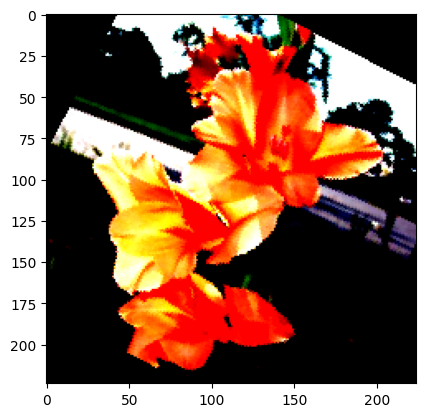

Label: 42


In [2]:
train_features, train_labels = next(iter(train_dataloader))
img = train_features[0].permute(1, 2, 0)
label = train_labels[0]
plt.imshow(img)
plt.show()
print(f"Label: {label}")

In [3]:
import torch.nn as nn
import torch.nn.functional as F
# Get cpu, gpu or mps device for training.

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 2, 1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 2, 1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 3, 1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, 2, 1, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(512, 1024, 3, 1, padding=1)
        self.bn6 = nn.BatchNorm2d(1024)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(9216, 1024)
        self.bn7 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512)
        self.bn8 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 256)
        self.bn9 = nn.BatchNorm1d(256)
        self.fc4 = nn.Linear(256, 102)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        x = self.pool(F.relu(self.bn6(self.conv6(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.bn7(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn8(self.fc2(x)))
        x = F.relu(self.bn9(self.fc3(x)))
        x = self.fc4(x)
        return self.logsoftmax(x)

model = NeuralNetwork().to(device)

learning_rate = 1e-4
batch_size = 64
epochs = 200

In [5]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min',factor=0.5, patience=5)

In [6]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)

    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)  # move data to device
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 1 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):

    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)  # move data to device
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss

In [7]:
import time

loss_fn = nn.NLLLoss()

# Define early stopping parameters
patience = 20
min_delta = 0.001

best_loss = float('inf')
counter = 0

# Timer
start_time = time.time()

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    validation_loss = test_loop(validation_dataloader, model, loss_fn)

    scheduler.step(validation_loss)

    # Early stopping logic
    if validation_loss < best_loss - min_delta:
        best_loss = validation_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

end_time = round((time.time()-start_time)/60, 3)

test_loop(test_dataloader, model, loss_fn)

print("Done! This took", end_time, "minutes")


Epoch 1
-------------------------------


C:\Users\keela\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
C:\Users\keela\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


loss: 4.663817  [   64/ 1020]
loss: 4.612872  [  128/ 1020]
loss: 4.691854  [  192/ 1020]
loss: 4.672102  [  256/ 1020]
loss: 4.528636  [  320/ 1020]
loss: 4.612244  [  384/ 1020]
loss: 4.648519  [  448/ 1020]
loss: 4.609071  [  512/ 1020]
loss: 4.643338  [  576/ 1020]
loss: 4.486660  [  640/ 1020]
loss: 4.550166  [  704/ 1020]
loss: 4.506950  [  768/ 1020]
loss: 4.426476  [  832/ 1020]
loss: 4.533035  [  896/ 1020]
loss: 4.475264  [  960/ 1020]
loss: 4.506138  [ 1020/ 1020]
Test Error: 
 Accuracy: 1.2%, Avg loss: 4.629425 

Epoch 2
-------------------------------
loss: 4.386196  [   64/ 1020]
loss: 4.328137  [  128/ 1020]
loss: 4.370725  [  192/ 1020]
loss: 4.351007  [  256/ 1020]
loss: 4.316130  [  320/ 1020]
loss: 4.288790  [  384/ 1020]
loss: 4.308700  [  448/ 1020]
loss: 4.224675  [  512/ 1020]
loss: 4.252985  [  576/ 1020]
loss: 4.372190  [  640/ 1020]
loss: 4.295465  [  704/ 1020]
loss: 4.321399  [  768/ 1020]
loss: 4.252356  [  832/ 1020]
loss: 4.256810  [  896/ 1020]
loss: 4.1

In [8]:
# Save the model
torch.save(model.state_dict(), 'model.pth')

In [9]:
# Load the model
model = NeuralNetwork()
model.load_state_dict(torch.load('model.pth'))
model.eval()  # set the model to evaluation mode after loading

NeuralNetwork(
  (conv1): Conv2d(3, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, tra